In [167]:
import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate, KFold, LeaveOneOut
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import mean_squared_error, make_scorer, pairwise
import matplotlib.pyplot as plt

In [168]:
np.set_printoptions(threshold=sys.maxsize)
data = pd.read_csv('C:/Users/dcfra/GR_capstone_public/data/ML_data.csv') # already scaled
del data['Unnamed: 0']
n = data.shape[0]
y_vars = ['AAL','SPEEDMAX','JUMPS','PHYSIOLOAD','EXERTIONS','DISTANCE']
Y = np.array(StandardScaler().fit_transform(data[y_vars])) # 108 x 6
indicators = pd.get_dummies(data[['HALF','ATHLETE']],dtype=float)
features = data.drop(pd.Index(y_vars + ['ATHLETE','DATE','HALF']),axis=1)
x_vars = list(indicators.columns) + list(features.columns)

X_full = np.c_[np.array(indicators),StandardScaler().fit_transform(features)]
X_one = np.ones((n,1))
X_red = np.c_[np.array(indicators),StandardScaler().fit_transform(np.array(data.TIME).reshape(-1,1))]

In [169]:
print(data.shape)
data.head().drop("ATHLETE",axis=1)

(108, 18)


,DATE,HALF,TIME,AAL,SPEEDMAX,JUMPS,PHYSIOLOAD,EXERTIONS,DISTANCE,JUMP_HEIGHT_IMP_DIS,ECCENTRIC_MEAN_FORCE,TAKEOFF_PEAK_FORCE,CONCENTRIC_PEAK_FORCE,TOTAL_WORK,ECCENTRIC_DECELERATION_IMPULSE,CONCENTRIC_IMPULSE,POSITIVE_TAKEOFF_IMPULSE
0,2023-11-08,2,37.783333,298.104293,5.515621,14,290.095548,67,1771.697621,44.824550,361.892323,927.2835,927.283522,924.436903,116.714353,209.474818,329.970152
1,2023-11-08,1,36.283333,455.827187,5.901390,19,467.087056,88,2852.636089,44.824550,361.892323,927.2835,927.283522,924.436903,116.714353,209.474818,329.970152
2,2023-11-12,2,44.016667,401.437078,5.768578,21,415.109247,99,2535.192538,43.525294,359.073153,892.2985,892.298307,906.341076,113.526805,205.833599,323.002744
3,2023-11-12,1,35.050000,346.990449,6.653042,13,356.234070,64,2175.624768,43.525294,359.073153,892.2985,892.298307,906.341076,113.526805,205.833599,323.002744
4,2023-12-06,2,30.250000,347.494722,5.785975,15,374.664116,94,2288.182410,42.245500,359.670721,885.9780,885.978153,912.667724,119.610594,204.663645,327.719492


In [176]:
def response_cv(cv,var):
    if type(var) == str:
        return -np.mean(cv[f'test_{var}'])
    else:
        return [-np.mean(cv[f'test_{var_i}']) for var_i in var]
    
def rmse_score(y_true, y_pred,output_index):
    return mean_squared_error(y_true[:, output_index], y_pred[:, output_index],squared = False)

scorers = {
    f'{y_vars[i]}': make_scorer(rmse_score, output_index=i, greater_is_better=False,response_method="predict")
    for i in range(Y.shape[1])
}

loo = LeaveOneOut()
cv_one = cross_validate(MultiOutputRegressor(LinearRegression()), X_one,Y, cv=loo, scoring=scorers, return_train_score=False,verbose = 0,n_jobs = -1)
cv_redreg = cross_validate(MultiOutputRegressor(LinearRegression()), X_red,Y, cv=loo, scoring=scorers, return_train_score=False,verbose = 0,n_jobs = -1)
cv_fullreg = cross_validate(MultiOutputRegressor(LinearRegression()), X_full,Y, cv=loo, scoring=scorers, return_train_score=False,verbose = 0,n_jobs = -1)


In [171]:
alphas = np.logspace(-4, 4, 100)
folds =  KFold(n_splits=10)
# Placeholder for the average LOOCV RMSE for each response and each alpha
avg_loocv_rmse = np.zeros((6, len(alphas)))

# Perform LOOCV for each response
for i, alpha in enumerate(alphas):
    rmses = np.zeros(6)
    for response_index in range(6):
        y = Y[:, response_index]
        y_preds = np.zeros(n)
        for train_index, test_index in folds.split(X_full):
            X_train, X_test = X_full[train_index], X_full[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model = Ridge(alpha=alpha)
            model.fit(X_train, y_train)
            y_preds[test_index] = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y, y_preds))
        rmses[response_index] = rmse
    avg_loocv_rmse[:, i] = rmses

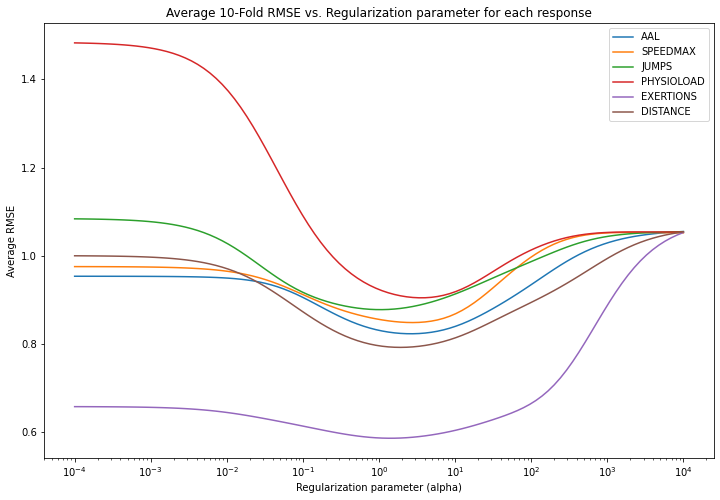

In [177]:
# Plot the average LOOCV RMSE for each response
plt.figure(figsize=(12, 8))
for response_index in range(6):
    plt.plot(alphas, avg_loocv_rmse[response_index], label = y_vars[response_index])
plt.xscale('log')
plt.xlabel('Regularization parameter (alpha)')
plt.ylabel('Average RMSE')
plt.title('Average 10-Fold RMSE vs. Regularization parameter for each response')
plt.legend()
plt.grid(False)
plt.show()

In [178]:
min_index = int(np.squeeze(np.where(avg_loocv_rmse[4] == min(avg_loocv_rmse[4]))))
alpha = alphas[min_index]
print(alpha)

1.3219411484660315


In [179]:
# model = MultiOutputRegressor(LinearRegression())
# model = MultiOutputRegressor(GradientBoostingRegressor())
# model = RandomForestRegressor(n_estimators = 100,max_depth=20,n_jobs=-1)
# model = RegressorChain(LinearRegression())
model = Ridge(alpha = alpha)
# model = PLSRegression(5,scale=False)
# model = KernelRidge(kernel="poly")


In [180]:
rfe_model = RFECV(model,step=1,verbose=0,min_features_to_select=1,cv=loo,n_jobs=-1,scoring='neg_root_mean_squared_error')
selector = rfe_model.fit(X_full,Y)
[string for string, flag in zip(x_vars, selector.support_) if flag]

['ATHLETE_Akuel Kot',
 'ATHLETE_Brendan Wenzel',
 'ATHLETE_Caden Powell',
 'ATHLETE_Cam Manyawu',
 'ATHLETE_Sam Griffin',
 'TIME',
 'ECCENTRIC_MEAN_FORCE',
 'TOTAL_WORK',
 'ECCENTRIC_DECELERATION_IMPULSE',
 'POSITIVE_TAKEOFF_IMPULSE']

In [181]:
cv_red = cross_validate(model, X_red,Y, cv=loo, scoring=scorers, return_train_score=False,verbose = 0,n_jobs = -1)
cv_full = cross_validate(model, X_full,Y, cv=loo, scoring=scorers, return_train_score=False,verbose = 0,n_jobs = -1)

X_cut = X_full[:,selector.support_]
cv_cut = cross_validate(model, X_cut,Y, cv=loo, scoring=scorers, return_train_score=False,verbose = 0,n_jobs = -1)
print(f'Intercept Only Prediction Error: {[np.sqrt(mean_squared_error(Y[:,i],LinearRegression().fit(X_one,Y[:,i]).predict(X_one))) for i in range(0,6)]}')
print(f'Intercept Only Regression: {response_cv(cv_one,y_vars)}')
print(f'Kinexon Only Regression: {response_cv(cv_redreg,y_vars)}')
print(f'Full Model Regression: {response_cv(cv_fullreg,y_vars)}')
print('')
print(f'Kinexon Only Model: {response_cv(cv_red,y_vars)}')
print(f'Full Model: {response_cv(cv_full,y_vars)}')
print(f'Reduced Model: {response_cv(cv_cut,y_vars)}')

Intercept Only Prediction Error: [0.9999999999999999, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0]
Intercept Only Regression: [0.8321766632486501, 0.8066830240617088, 0.8184664372521508, 0.8195727721364716, 0.8379739347666294, 0.8489394624939431]
Kinexon Only Regression: [0.6073845129515499, 0.6135239950244693, 0.6622404691045817, 0.6550994034215907, 0.4874632454698515, 0.5954516056827082]
Full Model Regression: [0.6335552131226657, 0.6518834454932204, 0.7111319642480203, 0.6847763101880558, 0.4824851330406385, 0.6218268476935322]

Kinexon Only Model: [0.6084610720805824, 0.6151707065014812, 0.6613866923269993, 0.656452421351873, 0.49394199421510954, 0.5982386556920845]
Full Model: [0.619571959760036, 0.627586440214407, 0.6930523241167463, 0.6632772460341355, 0.4759490295581478, 0.6052680706846121]
Reduced Model: [0.6021469461365204, 0.6067398432841138, 0.6705058320513392, 0.6488443754895518, 0.4837506585342457, 0.5897280334964939]
